In [1]:
import math

from matplotlib import pyplot as plt
from torch import Tensor

from src.common.log import logger
from src.dataset.tno_dataset_collection import TnoDatasetCollection
from src.inverse_problems.compressed_sensing_problem import (
    TotalEmissionsCompressedSensingExperiment,
)
from src.inverse_problems.footprints.footprint_loader import load_gaussian_plume_footprint
from src.inverse_problems.inverse_problems_solver import (
    BasisPursuitSolver,
    SparsityTransform,
    GenerativeModelSolver,
    LeastSquaresSolver,
    SparseGenerativeModelSolver,
)
from src.models.common.metrics import relative_error

In [2]:
CITY = "Munich"

x = TnoDatasetCollection().get_single_case_study_city_emission_field(city=CITY, year=2018).sum(dim=0)

[INFO] > Loading TNO data from '/home/must1d/Repositories/inventory-embeddings/data/TNO-GHGco-1km/TNO_by_city/TNO_GHGco_2015_highres_by_city.csv'
[INFO] > Loading TNO data from '/home/must1d/Repositories/inventory-embeddings/data/TNO-GHGco-1km/TNO_by_city/TNO_GHGco_2018_highres_by_city.csv'
[INFO] > Test Set has 13 unique cites!                          
	Dresden, Großzschocher, Magdeburg, Gdynia, Hamburg, Prague, Aachen, Innsbruck, Győr, Reims, Szczecin, Duisburg, Siegen
[INFO] > Validation Set has 15 unique cites!
	Zielona Góra, Frankfurt am Main, Kalisz, Brussels, Koblenz, Linz, Angers, Kassel, Southampton, Bydgoszcz, Bielefeld, Erfurt, Ingolstadt, Nijmegen, Wałbrzych
[INFO] > Training Set has 74 unique cites!
	Le Havre, Freiburg, Würzburg, Apeldoorn, Brno, Hannover, Orléans, Rostock, Wrocław, Dijon, Amiens, Hastings, Bremen, Kiel, Odense, Leeds, Southend-on-Sea, Strasbourg, Reading, Sunderland, Ipswich, Breda, Charleroi, Kingston upon Hull, Köln, Norwich, Besançon, Metz, Saint Pete

In [5]:
sensing_matrix = load_gaussian_plume_footprint(num_stations=30)

In [9]:
ls_solver = LeastSquaresSolver()

bp_solver = BasisPursuitSolver()
bp_solver_dwt = BasisPursuitSolver(transform=SparsityTransform.DWT)
bp_solver_dct = BasisPursuitSolver(transform=SparsityTransform.DCT)

gen_solver_256 = GenerativeModelSolver.from_vae_model_name("256", plot_loss=True)
gen_solver_512 = GenerativeModelSolver.from_vae_model_name("512", plot_loss=True)
gen_solver_1024 = GenerativeModelSolver.from_vae_model_name("1024", plot_loss=True)
gen_solver_2048 = GenerativeModelSolver.from_vae_model_name("2048", plot_loss=True)

gen_solver_512_munich = GenerativeModelSolver.from_vae_model_name("512_munich", plot_loss=True)
gen_solver_2048_munich = GenerativeModelSolver.from_vae_model_name("2048_munich", plot_loss=True)

sparse_gen_solver_256 = SparseGenerativeModelSolver.from_vae_model_name("256", plot_loss=True)
sparse_gen_solver_512 = SparseGenerativeModelSolver.from_vae_model_name("512", plot_loss=True)
sparse_gen_solver_1024 = SparseGenerativeModelSolver.from_vae_model_name("1024", plot_loss=True)
sparse_gen_solver_2048 = SparseGenerativeModelSolver.from_vae_model_name("2048", plot_loss=True)

sparse_gen_solver_256_munich = SparseGenerativeModelSolver.from_vae_model_name("256_munich", plot_loss=True)
sparse_gen_solver_512_munich = SparseGenerativeModelSolver.from_vae_model_name("512_munich", plot_loss=True)
sparse_gen_solver_1024_munich = SparseGenerativeModelSolver.from_vae_model_name("1024_munich", plot_loss=True)
sparse_gen_solver_2048_munich = SparseGenerativeModelSolver.from_vae_model_name("2048_munich", plot_loss=True)

In [7]:
snr_db_list = [5, 8, 11, 14, 17, 20, 23, 26, 29, 32, 35, 38]

In [11]:
ls_reconstruction = []
sparse_reconstruction = []
sparse_reconstruction_dwt = []
sparse_reconstruction_dct = []
gen_model_munich_2048 = []
gen_model_munich_256 = []
gen_model_2048 = []
gen_model_256 = []


for snr_db in snr_db_list:
    snr = math.pow(10, snr_db / 10)
    problem = TotalEmissionsCompressedSensingExperiment.generate_from_sensing_matrix(
        x,
        Tensor(sensing_matrix),
        snr=snr
    )
    # ls_reconstruction.append(relative_error(x, problem.solve(ls_solver)))
    # sparse_reconstruction.append(relative_error(x, problem.solve(bp_solver)))
    # sparse_reconstruction_dwt.append(relative_error(x, problem.solve(bp_solver_dwt)))
    sparse_reconstruction_dct.append(relative_error(x, problem.solve(bp_solver_dct)))
    logger.info(f"SNR {snr} done!")

[INFO] > SNR 3.1622776601683795 done!
[INFO] > SNR 6.309573444801933 done!
[INFO] > SNR 12.589254117941675 done!
[INFO] > SNR 25.118864315095795 done!
[INFO] > SNR 50.11872336272722 done!
[INFO] > SNR 100.0 done!
[INFO] > SNR 199.52623149688787 done!
[INFO] > SNR 398.1071705534973 done!
[INFO] > SNR 794.3282347242813 done!
[INFO] > SNR 1584.893192461114 done!
[INFO] > SNR 3162.2776601683795 done!
[INFO] > SNR 6309.57344480193 done!


[INFO] > SNR 3.1622776601683795 done!
[INFO] > SNR 6.309573444801933 done!
[INFO] > SNR 12.589254117941675 done!
[INFO] > SNR 25.118864315095795 done!
[INFO] > SNR 50.11872336272722 done!
[INFO] > SNR 100.0 done!
[INFO] > SNR 199.52623149688787 done!
[INFO] > SNR 398.1071705534973 done!
[INFO] > SNR 794.3282347242813 done!
[INFO] > SNR 1584.893192461114 done!
[INFO] > SNR 3162.2776601683795 done!
[INFO] > SNR 6309.57344480193 done!


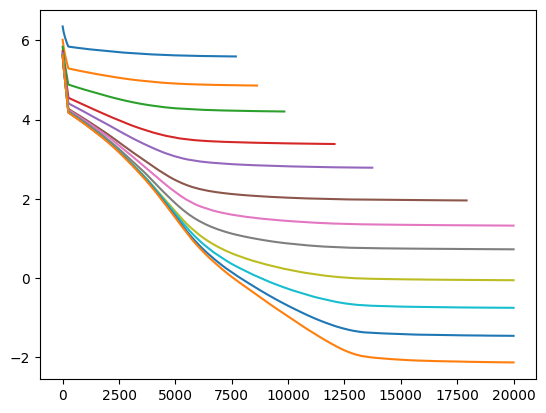

In [12]:
for snr_db in snr_db_list:
    snr = math.pow(10, snr_db / 10)
    problem = TotalEmissionsCompressedSensingExperiment.generate_from_sensing_matrix(
        x,
        Tensor(sensing_matrix),
        snr=snr
    )
    gen_model_munich_2048.append(relative_error(x, problem.solve(sparse_gen_solver_2048_munich)))
    logger.info(f"SNR {snr} done!")

[INFO] > SNR 3.1622776601683795 done!
[INFO] > SNR 6.309573444801933 done!
[INFO] > SNR 12.589254117941675 done!
[INFO] > SNR 25.118864315095795 done!
[INFO] > SNR 50.11872336272722 done!
[INFO] > SNR 100.0 done!
[INFO] > SNR 199.52623149688787 done!
[INFO] > SNR 398.1071705534973 done!
[INFO] > SNR 794.3282347242813 done!
[INFO] > SNR 1584.893192461114 done!
[INFO] > SNR 3162.2776601683795 done!
[INFO] > SNR 6309.57344480193 done!


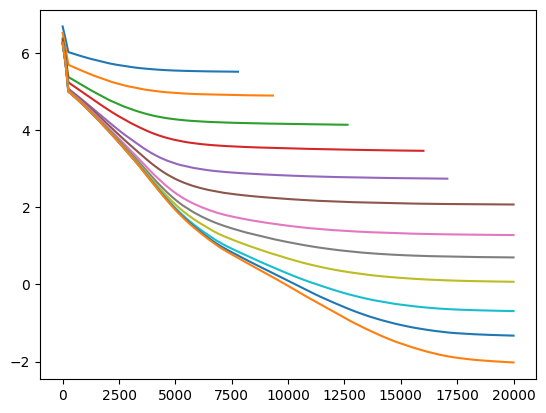

In [14]:
for snr_db in snr_db_list:
    snr = math.pow(10, snr_db / 10)
    problem = TotalEmissionsCompressedSensingExperiment.generate_from_sensing_matrix(
        x,
        Tensor(sensing_matrix),
        snr=snr
    )
    gen_model_2048.append(relative_error(x, problem.solve(sparse_gen_solver_2048)))
    logger.info(f"SNR {snr} done!")

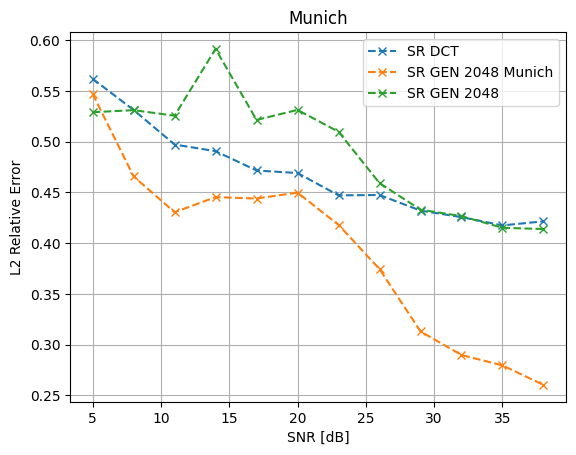

In [15]:
# plt.plot(snr_db_list, ls_reconstruction, "x--", label="LS")
# plt.plot(snr_db_list, sparse_reconstruction, "x--", label="SR")
# plt.plot(snr_db_list, sparse_reconstruction_dwt, "x--", label="SR DWT")
plt.plot(snr_db_list, sparse_reconstruction_dct, "x--", label="SR DCT")
plt.plot(snr_db_list, gen_model_munich_2048, "x--", label="SR GEN 2048 Munich")
plt.plot(snr_db_list, gen_model_2048, "x--", label="SR GEN 2048")

plt.xlabel("SNR [dB]")
plt.ylabel("L2 Relative Error")

plt.title("Munich")
plt.grid()

plt.legend()

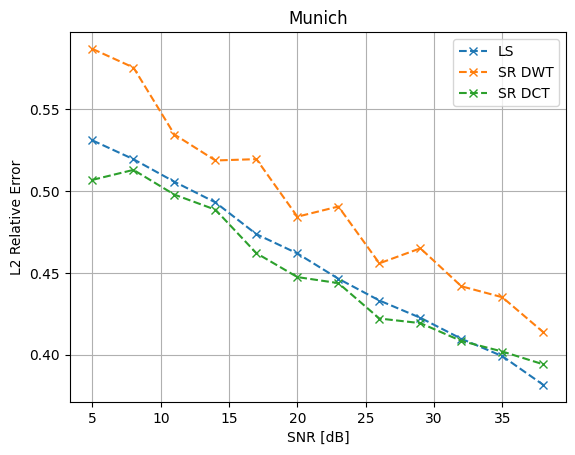

In [8]:
plt.plot(snr_db_list, ls_reconstruction, "x--", label="LS")
plt.plot(snr_db_list, sparse_reconstruction_dwt, "x--", label="SR DWT")
plt.plot(snr_db_list, sparse_reconstruction_dct, "x--", label="SR DCT")

plt.xlabel("SNR [dB]")
plt.ylabel("L2 Relative Error")

plt.title("Munich")
plt.grid()

plt.legend()